# Detecting Linux system hacking activities




## 1. Data preparation and exploration 

**1.1 Creating Spark Session**

1.1.1. Create a SparkConf object for using as many local cores as possible, for a proper application name, and for changing the max partition byte configuration to enable a minimum of 2 partitions when reading each file in Spark SQL (so each dataframe  should have at least 4 partitions when reading from the given datafiles).

In [1]:
# Code to create a SparkContext object using SparkSession

# Import SparkConf class into program
from pyspark import SparkConf

# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
# If we want Spark to run locally with 'k' worker threads, we can specify as "local[k]".
master = "local[*]"
# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "app"
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name).set("spark.sql.files.maxPartitionBytes", 26000000)

- `spark.sql.files.maxPartitionBytes` function is used to set the partition bytes to 26 MB to get 5 partitions in total of one dataframe. As one `.csv` file is approximately of 60MB so 26MB of data will be set at each partition and hence we have 2 partitions for each datafile and 5 partition for the whole dataframe.

1.1.2. Then create a SparkSession using the SparkConf object.

In [2]:
# Import SparkContext and SparkSession classes
from pyspark import SparkContext 
from pyspark.sql import SparkSession 

# Using SparkConf object to create a SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

**1.2 Loading the data**

1.2.1. Load each activity data into a Spark dataframe and cache the data. Then print out the row count of each dataframe

In [3]:
# to get all the sql type functions like StructType(), IntegerType() etc.
from pyspark.sql.types import *

# provide the required schema for each dataframe

# for process activity dataframe
process_schema = StructType([
    StructField('ts', IntegerType(), False),
    StructField('PID', IntegerType(), False),
    StructField('TRUN', IntegerType(), False),
    StructField('TSLPI', IntegerType(), False),
    StructField('TSLPU', IntegerType(), False),
    StructField('POLI', StringType(), False),
    StructField('NICE', IntegerType(), False),
    StructField('PRI', IntegerType(), False),
    StructField('RTPR', IntegerType(), False),
    StructField('CPUNR', IntegerType(), False),
    StructField('Status', StringType(), False),
    StructField('EXC', IntegerType(), False),
    StructField('State', StringType(), False),
    StructField('CPU', FloatType(), False),
    StructField('CMD', StringType(), False),
    StructField('attack', IntegerType(), False),
    StructField('type', StringType(), False),
    ])

# for memory activity dataframe
memory_schema = StructType([
    StructField('ts', IntegerType(), False),
    StructField('PID', IntegerType(), False),
    StructField('MINFLT', StringType(), False),
    StructField('MAJFLT', StringType(), False),
    StructField('VSTEXT', StringType(), False),
    StructField('VSIZE', FloatType(), False),
    StructField('RSIZE', StringType(), False),
    StructField('VGROW', StringType(), False),
    StructField('RGROW', StringType(), False),
    StructField('MEM', FloatType(), False),
    StructField('CMD', StringType(), False),
    StructField('attack', IntegerType(), False),
    StructField('type', StringType(), False),
    ])

In [4]:
# read the data files in tweo dataframes using the provided schema
df_process = spark.read.format('csv')\
            .option('header',True).option('escape','"')\
            .load('linux_process_*.csv', schema=process_schema)

df_memory = spark.read.format('csv')\
            .option('header',True).option('escape','"')\
            .load('linux_memory_*.csv',schema=memory_schema)

# to cache the dataframe for extensive use
df_process.cache()
df_memory.cache()

DataFrame[ts: int, PID: int, MINFLT: string, MAJFLT: string, VSTEXT: string, VSIZE: float, RSIZE: string, VGROW: string, RGROW: string, MEM: float, CMD: string, attack: int, type: string]

In [5]:
# to get the row count
df_memory.count()

2000000

In [6]:
# to get the row count
df_process.count()

1927968

1.2.2. For each column in each dataframe above - 
- Check the null data (if any) and print out the corresponding count in each column.
- Are these columns 'MINFLT', 'MAJFLT', 'VSTEXT', 'RSIZE', 'VGROW', 'RGROW' in memory data following the datatype from the metadata file? If not, please transform them into the proper formats

In [7]:
# to import all the sql function like isnan(), rand() etc.
from pyspark.sql.functions import *

In [8]:
# to get the count of null values in each column of the dataframe
df_memory.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_memory.columns]).show()

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



In [9]:
# to get the count of null values in each column of the dataframe
df_process.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_process.columns]).show()

+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
| ts|PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|CMD|attack|type|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+
|  0|  0|   0|    0|    0|   0|   0|  0|   0|    0|     0|  0|    0|  0|  0|     0|   0|
+---+---+----+-----+-----+----+----+---+----+-----+------+---+-----+---+---+------+----+



In [10]:
# the following link is referred to use regexp_replace function
# https://stackoverflow.com/a/35544166
df_memory = df_memory.withColumn('MINFLT', regexp_replace(col('MINFLT'), 'K', '000'))
df_memory = df_memory.withColumn('VSTEXT', regexp_replace(col('VSTEXT'), 'K', '000'))
df_memory = df_memory.withColumn('RSIZE', regexp_replace(col('RSIZE'), 'K', '000'))
df_memory = df_memory.withColumn('VGROW', regexp_replace(col('VGROW'), 'K', '000'))
df_memory = df_memory.withColumn('RGROW', regexp_replace(col('RGROW'), 'K', '000'))
df_memory = df_memory.withColumn('MAJFLT', regexp_replace(col('MAJFLT'), '224.2M', '224200000'))
df_memory = df_memory.withColumn('MAJFLT', regexp_replace(col('MAJFLT'), '224.4M', '224400000'))
df_memory = df_memory.withColumn('RSIZE', regexp_replace(col('RSIZE'), '224.2M', '224200000'))
df_memory = df_memory.withColumn('RSIZE', regexp_replace(col('RSIZE'), '224.4M', '224400000'))                                 

In [11]:
# to correct the VGROW column
df_memory = df_memory.withColumn('VGROW', regexp_replace(col('VGROW'), ' ', ''))

In [12]:
# casting the columns back to their datatypes
df_memory = df_memory.withColumn('MINFLT', df_memory['MINFLT'].cast(FloatType()))
df_memory = df_memory.withColumn('MAJFLT', df_memory['MAJFLT'].cast(FloatType()))
df_memory = df_memory.withColumn('VSTEXT', df_memory['VSTEXT'].cast(FloatType()))
df_memory = df_memory.withColumn('RSIZE', df_memory['RSIZE'].cast(FloatType()))
df_memory = df_memory.withColumn('VGROW', df_memory['VGROW'].cast(FloatType()))
df_memory = df_memory.withColumn('RGROW', df_memory['RGROW'].cast(FloatType()))

In [13]:
# check the null values with the correct datatypes
df_memory.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_memory.columns]).show()

+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
| ts|PID|MINFLT|MAJFLT|VSTEXT|VSIZE|RSIZE|VGROW|RGROW|MEM|CMD|attack|type|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+
|  0|  0|     0|     0|     0|    0|    0|    0|    0|  0|  0|     0|   0|
+---+---+------+------+------+-----+-----+-----+-----+---+---+------+----+



**1.3 Exploring the data**

In [16]:
#get the number of attack from df_memory

df_memory.select("attack")\
         .groupBy('attack').agg(count('attack').alias('Counts'))\
         .orderBy("Counts", ascending=False)\
         .show()

+------+-------+
|attack| Counts|
+------+-------+
|     0|1794377|
|     1| 205623|
+------+-------+



In the memory activity dataframe, we have approximately 9 times more non-attack events compared to the attack events. 

In [17]:
#get the number of attack from df_process

df_process.select("attack")\
         .groupBy('attack').agg(count('attack').alias('Counts'))\
         .orderBy("Counts", ascending=False)\
         .show()

+------+-------+
|attack| Counts|
+------+-------+
|     0|1636604|
|     1| 291364|
+------+-------+



In the process activity dataframe, we have approximately 6 times more non-attack events compared to the attack events.

Due to this class imbalance in both the data, our ML prediction algorithm will better learn to predict non-attack events.

In [18]:
#get the attack type counts from df_process

df_process.select("type")\
          .where(col('type')!='normal')\
          .groupBy('type').agg(count('type').alias('Attack_types_count'))\
          .orderBy("Attack_types_count", ascending=False)\
          .show()

+---------+------------------+
|     type|Attack_types_count|
+---------+------------------+
|     ddos|             71603|
|      dos|             70721|
| password|             51409|
|injection|             41311|
| scanning|             38449|
|      xss|             17759|
|     mitm|               112|
+---------+------------------+



In [19]:
# to show the summary statistics

# use only the numeric columns
numcols=['ts', 'PID', 'MINFLT','MAJFLT', 'VSTEXT' ,'VSIZE', 'RSIZE', 'VGROW' ,'RGROW', 'MEM']

# make a new dataframe with numeric columns
df_mem_num = df_memory[numcols]

# use .describe() to get summary statistics
# use .toPandas() to get a better format
df_mem_num.describe().toPandas().head()

,summary,ts,PID,MINFLT,MAJFLT,VSTEXT,VSIZE,RSIZE,VGROW,RGROW,MEM
0,count,2000000,2000000,2000000,2000000,2000000,2000000,2000000,2000000,2000000,2000000
1,mean,1.55624581707609E9,4999.360446,983.344344,987846.587327216,46453.27415207521,4496.419966550712,23722.88866416576,984.4668735599683,483.17466255000073,0.003385164946130477
2,stddev,984463.368280377,4887.313351921466,19229.610980642174,1.484287423809902E7,658730.205154303,9046.338093354188,1986383.1808734871,86174.82585202341,1491.4761059171694,0.010943425702315173
3,min,1554216855,1007,0.0,0.0,0.0,0.0,-9728.0,-9392000.0,0.0,0.0
4,max,1558355716,53096,8050000.0,2.244E8,1.12E7,88040.0,2.244E8,1.116E7,98920.0,0.44


In [99]:
# for non-numeric column

df_memory.select("CMD")\
         .groupBy('CMD').agg(count('CMD').alias('CMD_Count'))\
         .orderBy("CMD_Count", ascending=False)\
         .show(10)

+----------+---------+
|       CMD|CMD_Count|
+----------+---------+
|      atop|   325985|
|   apache2|    89761|
| jfsCommit|    81714|
|  vmtoolsd|    77871|
|      Xorg|    49981|
|  nautilus|    48356|
|irqbalance|    44387|
|    compiz|    44356|
|  ostinato|    43024|
|     drone|    41392|
+----------+---------+
only showing top 10 rows



For Process Dataframe - 

In [21]:
# to show the summary statistics

# use only the numeric columns
ncols=['ts', 'PID','TRUN', 'TSLPI', 'TSLPU', 'NICE', 'PRI', 'RTPR', 'CPUNR', 'EXC', 'CPU']

# make a new dataframe with numeric columns
df_proc_num = df_process[ncols]

# use .describe() to get summary statistics
# use .toPandas() to get a better format
df_proc_num.describe().toPandas().head()

,summary,ts,PID,TRUN,TSLPI,TSLPU,NICE,PRI,RTPR,CPUNR,EXC,CPU
0,count,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968,1927968
1,mean,1.5563198311840394E9,5068.709770597852,0.0632287465352122,3.508334163222626,3.6100184235422994E-4,4.634469555511295,111.26826741937626,0.0,1.9210142491991569,0.030275398761805176,0.02238527309440533
2,stddev,771350.0248061233,4987.784329320476,0.24782587090416094,6.988459728531786,0.04421874419214584,8.403189864752058,22.62444506210293,0.0,1.5274047225902987,1.4619498567691795,0.13628943806203103
3,min,1554216855,1007,0,0,0,0,0,0,0,0,0.0
4,max,1557593017,53080,12,70,21,20,139,0,5,127,4.02


In [100]:
# for non-numeric POLI column
df_process.select("POLI")\
         .groupBy('POLI').agg(count('POLI').alias('POLI_Count'))\
         .orderBy("POLI_Count", ascending=False)\
         .show()

+----+----------+
|POLI|POLI_Count|
+----+----------+
|norm|   1861558|
|   0|     53216|
|   -|     13194|
+----+----------+



In [101]:
# for non-numeric Status column
df_process.select("Status")\
         .groupBy('Status').agg(count('Status').alias('Status_Count'))\
         .orderBy("Status_Count", ascending=False)\
         .show()

+------+------------+
|Status|Status_Count|
+------+------------+
|     -|     1416322|
|     0|      438984|
|    NE|       48602|
|     N|       23313|
|    NS|         743|
|     C|           3|
|    NC|           1|
+------+------------+



In [102]:
# for non-numeric State column
df_process.select("State")\
         .groupBy('State').agg(count('State').alias('State_Count'))\
         .orderBy("State_Count", ascending=False)\
         .show()

+-----+-----------+
|State|State_Count|
+-----+-----------+
|    S|    1676350|
|    I|      98986|
|    R|      84753|
|    E|      66410|
|    Z|       1118|
|    D|        344|
|    T|          7|
+-----+-----------+



In [103]:
# for non-numeric CMD column
df_process.select("CMD")\
         .groupBy("CMD").agg(count('CMD').alias('CMD_Count'))\
         .orderBy("CMD_Count", ascending=True)\
         .show(10)

+--------------+---------+
|           CMD|CMD_Count|
+--------------+---------+
| <kworker/2:2>|        1|
|<oneconf-upda>|        1|
|        <snap>|        1|
|kworker/5:3-me|        1|
|kworker/4:4-ev|        1|
|       <iconv>|        1|
|          curl|        1|
|  <sd_generic>|        1|
|kworker/1:3-me|        1|
|kworker/4:3-ev|        1|
+--------------+---------+
only showing top 10 rows



In [32]:
# !pip install pandas
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

For Process Activity - 

In [115]:
# sampled the dataframe and stored only numeric columns 
df = df_process.sample(False, 0.1, seed=0)
df_p = df['ts', 'PID','TRUN', 'TSLPI', 'TSLPU', 'NICE', 'PRI', 'RTPR', 'CPUNR', 'EXC', 'CPU', 'attack']
df_p = df_p.toPandas()

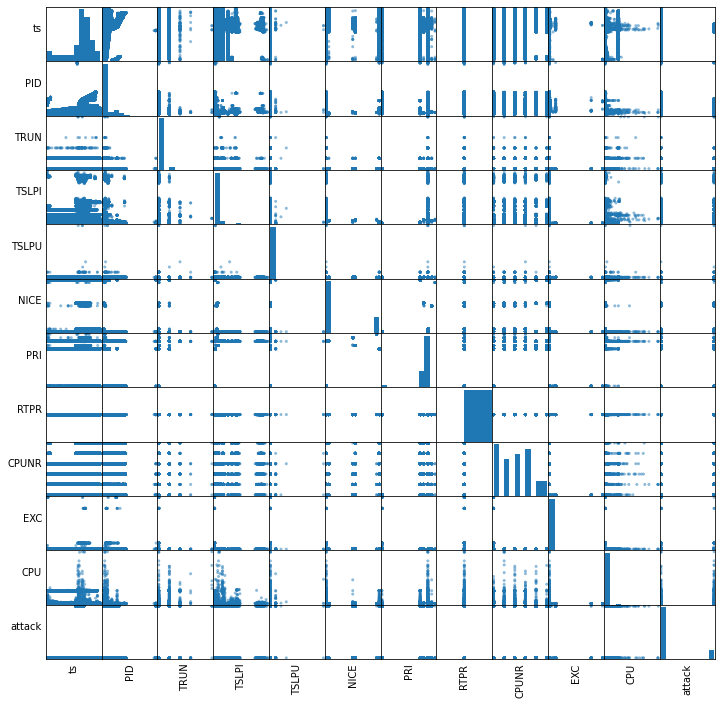

In [116]:
# used scatter_matrix function to plot the correlation plot
axs = pd.plotting.scatter_matrix(df_p, figsize=(12,12));

# Rotate axis labels and remove axis ticks
n = len(df_p.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

From the above plot, we see that - 
* The distribution of all the columns is skewed and not Symmetric.
* There is very less correlation between the individual variables.

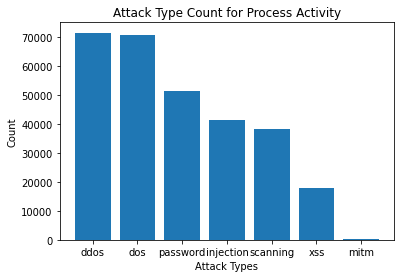

In [130]:
# group by the type column to get type count
# filter out the 'normal' type to include only attacks
attack_proc = df_process.select("type")\
          .where(col('type')!='normal')\
          .groupBy('type').agg(count('type').alias('Attack_types_count'))\
          .orderBy("Attack_types_count", ascending=False)

# plot a bar plot of the attack counts
x = [i.type for i in attack_proc.select('type').collect()]
y = [j.Attack_types_count for j in attack_proc.select('Attack_types_count').collect()]
plt.bar(x,y)
plt.title('Attack Type Count for Process Activity')
plt.xlabel('Attack Types')
plt.ylabel('Count')
plt.show()

The above plot, shows that **ddos** attack types are the maximum on the Process Activity and **mitm** attack types are minimum. In the distributed denial of service attack, the attacker seeks to make a machine or network resource unavailable to its intended users by overwhelming the network with more traffic than the server or network can accommodate. 

For Memory Activity - 

In [112]:
# sampled the dataframe and stored only numeric columns 
df_m = df_memory.sample(False, 0.1, seed=0)
df_mem = df_m['ts', 'PID', 'MINFLT','MAJFLT', 'VSTEXT' ,'VSIZE', 'RSIZE', 'VGROW' ,'RGROW', 'MEM', 'attack']
df_mem = df_mem.toPandas()

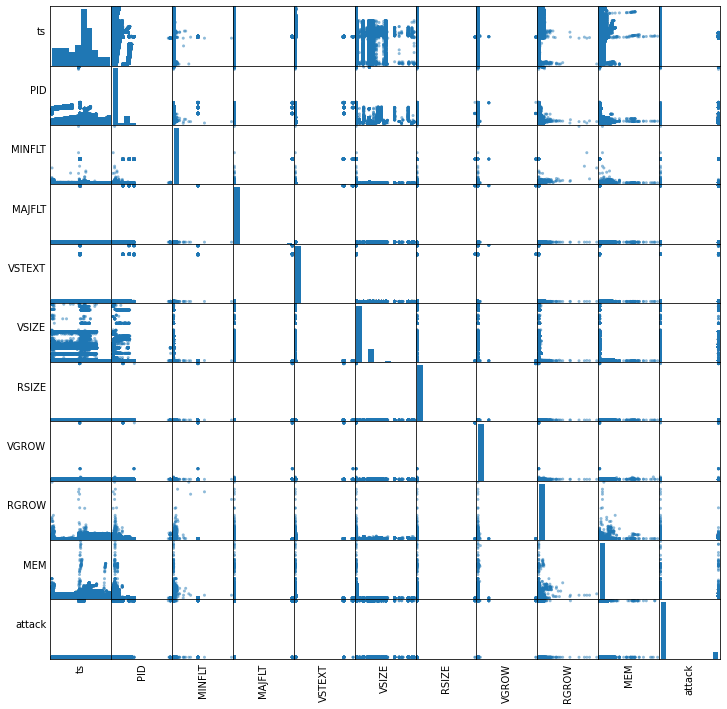

In [113]:
# used scatter_matrix function to plot the correlation plot
axs = pd.plotting.scatter_matrix(df_mem, figsize=(12,12));

# Rotate axis labels and remove axis ticks
n = len(df_mem.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

From the above plot, we see that - 
* The distribution of all the columns is skewed to the right and not Symmetric.
* There is very less correlation between the individual variables.

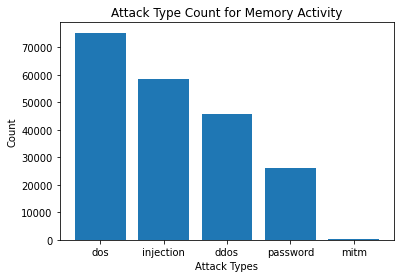

In [131]:
# group by the type column to get type count
# filter out the 'normal' type to include only attacks
attack_mem = df_memory.select("type")\
          .where(col('type')!='normal')\
          .groupBy('type').agg(count('type').alias('Attack_types_count'))\
          .orderBy("Attack_types_count", ascending=False)

x = [i.type for i in attack_mem.select('type').collect()]
y = [j.Attack_types_count for j in attack_mem.select('Attack_types_count').collect()]
plt.bar(x,y)
plt.title('Attack Type Count for Memory Activity')
plt.xlabel('Attack Types')
plt.ylabel('Count')
plt.show()

The above plot, shows that **dos** attack types are the maximum on the Memory Activity and **mitm** attack types are minimum. In the denial of service attack, the attacker seeks to make a machine or network resource unavailable to its intended users by temporarily or indefinitely disrupting services of a host connected to the Internet.

## 2. Feature extraction and ML training

**2.1 Preparing the training data and testing data**

2.1.1 Randomly split the dataset into 80% training data and 20% testing data for each use case

In [14]:
# to randomly split the dataframe
train_mem, test_mem = df_memory.randomSplit([0.8, 0.2], seed = 2020)

In [15]:
# to randomly split the dataframe
train_proc, test_proc = df_process.randomSplit([0.8, 0.2], seed = 2020)

For Memory Dataframe - 

In [16]:
# rebalancing the data according to the given conditions

# get the 20% of attack data
sampled_mem_attack = train_mem.sampleBy("attack", fractions={0: 0, 1: 0.2}, seed=0)

# convert the required non-attack data to fraction
# frac = (2 * attackdata)/ (non-attackdata)
frac = (2*sampled_mem_attack.count())/(train_mem.filter(col('attack')== 0).count())

# use the fraction to sample the required amount of non-attack data
sampled_mem_non_attack = train_mem.sampleBy("attack", fractions={0: frac, 1: 0}, seed=0)

# combine the attack and non-attack data to make the final training data 
# use rand() to shuffle the data
mem_train_data = sampled_mem_attack.union(sampled_mem_non_attack).orderBy(rand()) 

# cache the trainig data for later use
mem_train_data.cache()

DataFrame[ts: int, PID: int, MINFLT: float, MAJFLT: float, VSTEXT: float, VSIZE: float, RSIZE: float, VGROW: float, RGROW: float, MEM: float, CMD: string, attack: int, type: string]

In [18]:
# show the rebalanced training data
mem_train_data.show(5)

+----------+-----+------+------+-------+-------+-------+-----+------+----+-------------------+------+------+
|        ts|  PID|MINFLT|MAJFLT| VSTEXT|  VSIZE|  RSIZE|VGROW| RGROW| MEM|                CMD|attack|  type|
+----------+-----+------+------+-------+-------+-------+-----+------+----+-------------------+------+------+
|1556174443| 1457|   0.0|   0.0| 2219.0|  333.8|71104.0|  0.0|   0.0|0.02|               Xorg|     1|   dos|
|1558241866| 2365| 132.0| 233.6| 3384.0|    0.0|    0.0|  0.0|1024.0| 0.0|     gsd-disk-utili|     0|normal|
|1555676275| 4372|1955.0|   0.0|  148.0|17644.0| 2488.0|  0.0|   0.0| 0.0|               atop|     0|normal|
|1554803365|16363|   0.0|   0.0|    0.0|    0.0|    0.0|  0.0|   0.0| 0.0|     kworker/u256:2|     0|normal|
|1558216251| 6714| 132.0|   1.3|79064.0|    0.0|    0.0|  0.0|   0.0|0.01|Web-Content Content|     0|normal|
+----------+-----+------+------+-------+-------+-------+-----+------+----+-------------------+------+------+
only showing top 5 

For Process Dataframe - 

In [17]:
# rebalancing the data according to the given conditions

# get the 20% of attack data
sampled_proc_attack = train_proc.sampleBy("attack", fractions={0: 0, 1: 0.2}, seed=0)

# convert the required non-attack data to fraction
# frac = (2 * attackdata)/ (non-attackdata)
frac = (2*sampled_proc_attack.count())/(train_proc.filter(col('attack')== 0).count())

# use the fraction to sample the required amount of non-attack data
sampled_proc_non_attack = train_proc.sampleBy("attack", fractions={0: frac, 1: 0}, seed=0)

# combine the attack and non-attack data to make the final training data 
# use rand() to shuffle the data
proc_train_data = sampled_proc_attack.union(sampled_proc_non_attack).orderBy(rand()) 

# cache the trainig data for later use
proc_train_data.cache()

DataFrame[ts: int, PID: int, TRUN: int, TSLPI: int, TSLPU: int, POLI: string, NICE: int, PRI: int, RTPR: int, CPUNR: int, Status: string, EXC: int, State: string, CPU: float, CMD: string, attack: int, type: string]

In [19]:
# show the rebalanced training data
proc_train_data.show(5)

+----------+-----+----+-----+-----+----+----+---+----+-----+------+---+-----+---+--------------+------+--------+
|        ts|  PID|TRUN|TSLPI|TSLPU|POLI|NICE|PRI|RTPR|CPUNR|Status|EXC|State|CPU|           CMD|attack|    type|
+----------+-----+----+-----+-----+----+----+---+----+-----+------+---+-----+---+--------------+------+--------+
|1556281845| 2547|   0|    3|    0|norm|   0|120|   0|    2|     -|  0|    S|0.0|unity-panel-se|     0|  normal|
|1556710945| 4374|   0|    1|    0|norm|  20|100|   0|    0|     -|  0|    S|0.0|          atop|     0|  normal|
|1556506937| 1594|   0|    3|    0|norm|   0|120|   0|    0|     -|  0|    S|0.0|   packagekitd|     1|password|
|1556222675| 4253|   0|    1|    0|norm|   0|120|   0|    2|     0|  0|    S|0.0|kworker/u256:0|     1|    ddos|
|1554416005|17503|   0|    0|    0|norm|   0|120|   0|    3|     -|  0|    I|0.0|kworker/u256:0|     0|  normal|
+----------+-----+----+-----+-----+----+----+---+----+-----+------+---+-----+---+--------------+

**2.2 Preparing features, labels and models**

In [20]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

**For Process Activity**

In [21]:
# First, save the string columns in string list and numerical in the numerical columns list
stringInputCols = ['POLI' , 'Status', 'State']
numericInputCols = ['PID', 'TSLPI','NICE', 'CPU']

#stringIndexer
outputCols=[f'{x}_index' for x in stringInputCols]
indexer = StringIndexer(inputCols=stringInputCols, outputCols=outputCols, handleInvalid='keep')

#OHE
inputOHE = outputCols 
outputOHE = [f'{x}_vec' for x in stringInputCols]
encoder = OneHotEncoder(inputCols=inputOHE, outputCols=outputOHE)

#VectorAssembler
assemblerInputs = numericInputCols + outputOHE
assembler = VectorAssembler(inputCols = assemblerInputs, outputCol="features")

**For Memory Activity**

In [22]:
# Save the numerical in the numerical columns list
numericInputCols_mem = ['PID', 'MINFLT','MAJFLT','VSTEXT', 'RSIZE','VGROW','RGROW','MEM']

#VectorAssembler
assemblerInputs_mem  = numericInputCols_mem 
assembler_mem  = VectorAssembler(inputCols = assemblerInputs_mem, outputCol="features")

2.2.3 Prepare Estimators for Decision Tree and Gradient Boosted Tree model for each use case and include them into ML Pipelines for use case 1, 2.
* A maximum of two pipelines can be created for each use case

**Decision Tree**

In [23]:
# import the Decision Tree Estimator
from pyspark.ml.classification import DecisionTreeClassifier

# create an Decision Tree Estimator object
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'attack', maxDepth = 3)

In [24]:
# to make an ML pipeline
from pyspark.ml import Pipeline

# For Process Activity
stages_proc = [indexer,encoder,assembler,dt]
pipeline_proc = Pipeline(stages = stages_proc)

# For Memory Activity
stages_mem = [assembler_mem,dt]
pipeline_mem = Pipeline(stages = stages_mem)

**Gradient Boosted Tree**

In [25]:
# import the Gradient Boosted Tree Estimator
from pyspark.ml.classification import GBTClassifier

# create an Gradient Boosted Tree Estimator object
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'attack', maxDepth = 3 , maxIter = 10)

In [26]:
# For Process Activity
stages_proc_gbt = [indexer,encoder,assembler,gbt]
pipeline_proc_gbt = Pipeline(stages = stages_proc_gbt)

# For Memory Activity
stages_mem_gbt = [assembler_mem,gbt]
pipeline_mem_gbt = Pipeline(stages = stages_mem_gbt)

**2.3 Training and evaluating models**

2.3.1. For each use case, use the corresponding ML Pipeline from previous step to train the models on the rebalanced training data from 2.1.2. 
* Hint - each model training might take from 1min to 40min, depending on the complexity of the pipeline model, the amount of training data and the VM computing power.

**Decision Tree**

In [27]:
#For Process Activity
dtModel_proc = pipeline_proc.fit(proc_train_data)

#For Memory Activity
dtModel_mem = pipeline_mem.fit(mem_train_data)

**Gradient Boosted Tree**

In [28]:
#For Process Activity
gbtModel_proc = pipeline_proc_gbt.fit(proc_train_data)

#For Memory Activity
gbtModel_mem = pipeline_mem_gbt.fit(mem_train_data)

2.3.2. For each use case, test the models on the testing data from 2.1.1 and display the count of each combination of attack label and prediction label in given formats.

In [29]:
#Testing the obtained models

#Decision Tree
dtpredictions_proc = dtModel_proc.transform(test_proc)
dtpredictions_mem = dtModel_mem.transform(test_mem)

#Gradient Boosted Tree
gbtpredictions_proc = gbtModel_proc.transform(test_proc)
gbtpredictions_mem = gbtModel_mem.transform(test_mem)

In [30]:
# show confusion matrix
print('Decision Tree Models ----')
print('For Process Activity:\n')
dtpredictions_proc.groupBy('attack', 'prediction').count().show()
print('\nFor Memory Activity:\n')
dtpredictions_mem.groupBy('attack', 'prediction').count().show()
print('Gradient Boosted Tree Models ----')
print('For Process Activity:\n')
gbtpredictions_proc.groupBy('attack', 'prediction').count().show()
print('\nFor Memory Activity:\n')
gbtpredictions_mem.groupBy('attack', 'prediction').count().show()

Decision Tree Models ----
For Process Activity:

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 34723|
|     0|       0.0|289329|
|     1|       1.0| 23838|
|     0|       1.0| 38068|
+------+----------+------+


For Memory Activity:

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 29630|
|     0|       0.0|330014|
|     1|       1.0| 11535|
|     0|       1.0| 28967|
+------+----------+------+

Gradient Boosted Tree Models ----
For Process Activity:

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 33715|
|     0|       0.0|288583|
|     1|       1.0| 24846|
|     0|       1.0| 38814|
+------+----------+------+


For Memory Activity:

+------+----------+------+
|attack|prediction| count|
+------+----------+------+
|     1|       0.0| 28512|
|     0|       0.0|331673|
|     1|       1.0| 12653|
|     0|       1.0| 27308|
+------+

2.3.3. Compute the AUC, accuracy, recall and precision for the attack label from each model testing result using pyspark MLlib / ML APIs. Discuss which metric is more proper for measuring the model performance on identifying attacks.

In [31]:
# Use BinaryClassificationEvaluator to evaluate a model
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model Decision Tree
evaluator = BinaryClassificationEvaluator(labelCol='attack',rawPredictionCol="rawPrediction")

In [32]:
def compute_metrics(predictions):
    
    # Calculate the elements of the confusion matrix
    TN = predictions.filter('prediction = 0 AND attack = 0').count()
    TP = predictions.filter('prediction = 1 AND attack = 1').count()

    FN = predictions.filter('prediction = 0 AND attack = 1').count()
    FP = predictions.filter('prediction = 1 AND attack = 0').count()


    # calculate metrics by the confusion matrix
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    auc = evaluator.evaluate(predictions)

   
    return auc, accuracy, precision, recall    

In [33]:
# get the required values for models
proc_dt = compute_metrics(dtpredictions_proc)
mem_dt = compute_metrics(dtpredictions_mem)
proc_gbt = compute_metrics(gbtpredictions_proc)
mem_gbt = compute_metrics(gbtpredictions_mem)

# show metrics
print('Decision Tree Models ----')
print('For Process Activity:')

print('Area Under ROC :', proc_dt[0])
print('Accuracy :', proc_dt[1])
print('Precision :', proc_dt[2])
print('Recall :', proc_dt[3])

print('\nFor Memory Activity:')
print('Area Under ROC :', mem_dt[0])
print('Accuracy :',  mem_dt[1])
print('Precision :',  mem_dt[2])
print('Recall :',  mem_dt[3])

print('\nGradient Boosted Tree Models ----')
print('\nFor Process Activity:')
print('Area Under ROC :', proc_gbt[0])
print('Accuracy :', proc_gbt[1])
print('Precision :', proc_gbt[2])
print('Recall :', proc_gbt[3])

print('\nFor Memory Activity:')
print('Area Under ROC :', mem_gbt[0])
print('Accuracy :', mem_gbt[1])
print('Precision :', mem_gbt[2])
print('Recall :', mem_gbt[3])



Decision Tree Models ----
For Process Activity:
Area Under ROC : 0.4017474048352154
Accuracy : 0.8114017587405884
Precision : 0.38506768326171936
Recall : 0.4070627209234815

For Memory Activity:
Area Under ROC : 0.5719365701729139
Accuracy : 0.8535609502531576
Precision : 0.28480075058021825
Recall : 0.28021377383699747

Gradient Boosted Tree Models ----

For Process Activity:
Area Under ROC : 0.778548167265007
Accuracy : 0.8120805890796408
Precision : 0.3902921771913289
Recall : 0.42427554174279813

For Memory Activity:
Area Under ROC : 0.7813903132351491
Accuracy : 0.8605009171652347
Precision : 0.31663371787492806
Recall : 0.3073727681282643


For Decision Tree Models -

In [121]:
# to display top 5 features
d = dict(zip(dtModel_proc.stages[-2].getInputCols(), dtModel_proc.stages[-1].featureImportances))
print('Process Activity:\n',sorted(d.items(), key=lambda x: x[1], reverse=True)[:5])

Process Activity:
 [('PID', 0.40551097806515174), ('Status_vec', 0.08145196513737579), ('TSLPI', 0.0), ('NICE', 0.0), ('CPU', 0.0)]


In [122]:
# to display top 5 features
d = dict(zip(dtModel_mem.stages[-2].getInputCols(), dtModel_mem.stages[-1].featureImportances))
print('Memory Activity:\n',sorted(d.items(), key=lambda x: x[1], reverse=True)[:5])  

Memory Activity:
 [('PID', 0.42462763380574237), ('MINFLT', 0.41133887258576496), ('RGROW', 0.16403349360849268), ('MAJFLT', 0.0), ('VSTEXT', 0.0)]


For Gradient Boosted Tree Models -

In [123]:
# to display top 5 features
d = dict(zip(gbtModel_proc.stages[-2].getInputCols(), gbtModel_proc.stages[-1].featureImportances))
print('Process Activity:\n',sorted(d.items(), key=lambda x: x[1], reverse=True)[:5])  

Process Activity:
 [('PID', 0.4248024599672048), ('TSLPI', 0.26168494921138535), ('CPU', 0.06044854095661789), ('NICE', 0.04639897642383493), ('Status_vec', 0.015165289108291409)]


In [124]:
# to display top 5 features
d = dict(zip(gbtModel_mem.stages[-2].getInputCols(), gbtModel_mem.stages[-1].featureImportances))
print('Memory Activity:\n',sorted(d.items(), key=lambda x: x[1], reverse=True)[:5])  

Memory Activity:
 [('PID', 0.37299012843343626), ('MINFLT', 0.2528616828461373), ('RSIZE', 0.24403047637190547), ('VSTEXT', 0.0706555956020393), ('MEM', 0.021278208242896862)]


In [62]:
# Used the following link to get the ROC curve 
#https://stackoverflow.com/a/57342431

from pyspark.mllib.evaluation import BinaryClassificationMetrics

class CurveMetrics(BinaryClassificationMetrics):
    
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        for row in rdd.collect():
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

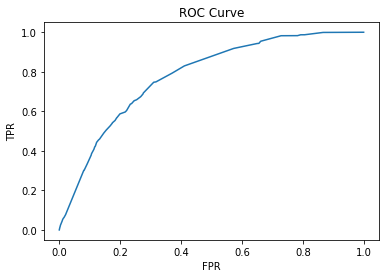

In [125]:
# Returns as a list (false positive rate, true positive rate)
preds = gbtpredictions_proc.select('attack','probability')\
                           .rdd.map(lambda row: (float(row['probability'][1]), float(row['attack'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(x_val, y_val)

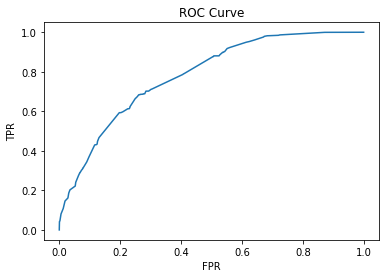

In [126]:
# Returns as a list (false positive rate, true positive rate)
preds = gbtpredictions_mem.select('attack','probability')\
                          .rdd.map(lambda row: (float(row['probability'][1]), float(row['attack'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.plot(x_val, y_val)

**Gradient Boosted Tree models are selected due to higher AUC values for both the cases.**

In [41]:
# For process activity

# Again rebalancing the data to get all the attack values
proc_attack = df_process.sampleBy("attack", fractions={0: 0, 1: 1}, seed=100)

# to get the twice the non-attack values
#frac_proc = (2 * attack_value)/(non-attack_value)
frac_proc = (2*proc_attack.count())/(df_process.filter(col('attack')== 0).count())

proc_non_attack = df_process.sampleBy("attack", fractions={0: frac_proc, 1: 0}, seed=100)

#combining the attack and non-attack dataframe
proc_rebal_data = proc_attack.union(proc_non_attack).orderBy(rand())

In [42]:
# For memory activity

# Again rebalancing the data to get all the attack values
mem_attack = df_memory.sampleBy("attack", fractions={0: 0, 1: 1}, seed=100)

# to get the twice the non-attack values
#frac_proc = (2 * attack_value)/(non-attack_value)
frac_mem = (2*mem_attack.count())/(df_memory.filter(col('attack')== 0).count())

mem_non_attack = df_memory.sampleBy("attack", fractions={0: frac_mem, 1: 0}, seed=100)

#combining the attack and non-attack dataframe
mem_rebal_data = mem_attack.union(mem_non_attack).orderBy(rand()) 

In [43]:
# caching both the dataframes for later use
mem_rebal_data = mem_rebal_data.cache()
proc_rebal_data = proc_rebal_data.cache()

In [44]:
# Training the selected GBT pipeline model on the rebalanced data

# For Process Activity
gbt_proc_model = pipeline_proc_gbt.fit(proc_rebal_data)

# For Memory Activity
gbt_mem_model = pipeline_mem_gbt.fit(mem_rebal_data)

In [45]:
#Save the best model
gbt_proc_model.save('AttackPrediction_from_Processmodel')
gbt_mem_model.save('AttackPrediction_from_Memorymodel')